# Machine Learning Project

In [ ]:
# Daniel Moskalchuk 293172
# Julia Tankiewicz 293719
# Nikita Bondarchuk 294478

The assignments below should be solved and documented as a project that will form the basis for the
examination. When solving the exercises it is important that you

  * document all relevant results and analyses that you have obtained/performed during the exercises.
  * try to relate your results to the theoretical background of the methods being applied.

Feel free to add cells if you need to.

Please hand in assignment 1-6 in a _**single**_ Jupyter notebook where you retain the questions outlined below. You are welcome to adapt code from the web (e.g. Kaggle kernels), but you **_must_** reference the original source in your notebook. In addition to _clean, well-documented code_ (i.e. functions with <a href="https://www.geeksforgeeks.org/python-docstrings/">docstrings</a>, etc), your notebook will be judged according to how well each step is explained (using Markdown). 

In general, direct questions regarding assignments 1, 4, 5 and 6 to Frederik, and questions regarding assignments 2, 3, and 7 to Richard. 

Last, but not least:
* Looking for an overview of the markdown language? The cheat sheet <a href="https://medium.com/ibm-data-science-experience/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed">here</a> might help.
* For the Python specific components of the exercises, you should not need constructs beyond those that are already included in the notebooks on the course's web-page (still you should not feel constrained by these, so feel free to be adventurous). You may, however, need to consult the documentation for some of the methods supplied by `sklearn`.

**Groups:** Create your own groups. May be across teams. 2-4 students per group. No one-person groups.


**Submission deadline:** Thursday, December 15 before 13.00 CET (Notebooks + presentation recording)

**Expected workload:** Each student is expected to spend around around 50 hours on the project.

### Deliverables
The teams have to submit three deliverables before the submission deadline: 1) a notebook of assignments 1-6, 2) a notebook of assignment 7, and 3) presentation video uploaded to some online platform e.g. YouTube, Vimeo, etc.

#### Notebook
The notebook contains all the code to explore the dataset, train the final model and documents each step clearly. If code is copied from another codebase such as Github or Stack Overflow it **_must_** be properly referenced.


#### Presentation
The presentation video should be 15 min long and should highlight the problem you are solving, interesting things you found in the data and the step involved in building up your model. At the exam we will discuss the presentation and ask questions about your project and submissions. A link to the video must be placed in the notebook for assignment 7.

### Randomness
For ALL random states, choose state = 69 so we can replicate your work.


## 1. The IceCat Dataset

__You should be able to do this exercise after Lecture 3.__

The IceCat Dataset, kindly provided to us by Stibo Systems, contains a large amount of data on different office products. As an example of "real-world" data, these data are imperfect and incomplete. As such, this exercise is not so much an exercise in creating a good machine learning model, but places a larger emphasis on "cleaning the data".

We are going to work with a subset of the IceCat Dataset. In particular, you will be provided with a zip file of 5,854 images of office products, each with the name "product ID".jpg. You will also be provided with a list of colors, `colors.txt`, which, when imported using the code below, is a list of tuples of the form `[("product ID", "color"), ...]`. (The code below assumes that `colors.txt` is in the same folder as the jupyter notebook. Feel free to change the code if you prefer a different organization of your files).

Your task is to clean up the data and construct a simple machine learning model (_e.g._, _k_-nearest neighbor) that can identify the color of a product. You have free hands - there is hardly any one "correct answer" - but you need to argue for your choices. Among other things, you probably need to think about the following as you work with the data:

* All of the images have different sizes.

* Some of the images are RGB images (3 layers), others are CMYK (4 layers), some might even be black-and-white (1 layer).

* Some colors are only represented by very few products.

* Some colors are very similar, such as "Purple" and "Violet".

* A product may have a particular color, but a packaging of a different color. Similarly, the color of, say, a computer monitor may be black, while the image of it could show a monitor that is turned on with a green screensaver.

* Many products are attributed to several colors, such as "Black, Blue" or even "Blue, Green, Orange, Violet, Yellow". Yet others are described as "Multicolor" or "Assorted colors".

Again, you have free hands in how you are going to solve these (and other) challenges, but you must argue for and reflect on your choices as you progress.


 ___---GLOBAL VARIABLES---___

In [1]:
# Import all necessary modules here:
#pip install opencv-python
#pip install keras
#pip install --no-cache-dir tensorflow
from pathlib import Path
import numpy as np
import ast
import pandas as pd
import matplotlib.pyplot as plt
import cv2 as cv
#from keras.preprocessing import image
#from tensorflow.keras.utils import load_img, img_to_array


In [18]:
# for some binning
color_mappings = {
  # source color => arr of colors associated with the source color
    'Grey' : ['Silver', 'Metallic', 'Aluminium', 'Stainless steel', 'Platinum', 'Graphite', 'Chrome', 'Anthracite','Light Grey','Charcoal','Titanium','Light grey'],
    'Purple' : ['Violet', 'Lavender', 'Fuchsia','Magenta'],
    'Transparent' : ['Translucent'],
    'Cream' : ['Beige', 'Sand', 'Tan','Cappuccino','Ivory'],
    'Brown' : ['Oak colour', 'Wood','Bronze'],
    'Cyan' : ['Turquoise', 'Aqua colour'],
    'White' : ['Pearl' ],
    'Pink' : ['Rose'],
    'Red' : ['Cherry', 'Bordeaux'],
    'Green' : ['Pine', 'Lime','Olive'],
    'Yellow' : ['Gold'],
    'Blue' : ['Navy'],
    'Multicolour' : ['Multi','Assorted colours']
}

inputDataMock = {
    'img_id': [],
    'red1': [], 'green1': [], 'blue1': [],
    'red2': [], 'green2': [], 'blue2': [],
    'red3': [], 'green3': [], 'blue3': [],
    'red4': [], 'green4': [], 'blue4': [],
    'red5': [], 'green5': [], 'blue5': [],
    'color': []
}

___---METHODS---___

In [19]:
# returns the source color in response to the associated color using the color_mappings
def colors_binning(initial_color):
    for source_color in color_mappings:
        if initial_color in color_mappings[source_color]: return source_color;
    return initial_color;

In [20]:
# returns a dataframe from colors.txt
def getCorrectAnswersDF():
    with open("datasets/1/colors.txt","r") as file:
        colors = ast.literal_eval(file.read())
        # lets create a dataframe
        d = {'pic_id': [], 'color': []}
        for row in colors:
            # check if there are more colors in one row
            colors_arr = row[1].split(", ")
            # if there are more than 1 color
            if(len(colors_arr) > 1):
                # insert a row for each color
                for color in colors_arr:  
                    d['pic_id'].append(row[0])
                    d['color'].append(colors_binning(color)) 
            else:
                d['pic_id'].append(row[0])
                d['color'].append(colors_binning(row[1])) 


        pic_colors = pd.DataFrame(data=d)
        return pic_colors;

In [21]:
def normalize_image(img, dimension=(64, 64), nr_of_colors = 16):
    # resize
    img_resized = cv.resize(img, dimension, interpolation=cv.INTER_AREA)
    
    if img_resized.shape == (64, 64):
        img_resized = cv.cvtColor(img_resized.astype('float32'),cv.COLOR_GRAY2RGB)
    elif img_resized.shape == (64, 64, 4):
        img_resized = cv.cvtColor(img_resized.astype('float32'),cv.COLOR_RGBA2RGB)
        
    # Lets compress the image using clustering
    # https://docs.opencv.org/3.0-beta/doc/py_tutorials/py_ml/py_kmeans/py_kmeans_opencv/py_kmeans_opencv.html
    criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    flags = cv.KMEANS_PP_CENTERS
    compactness, labels, centers = cv.kmeans(np.float32(img_resized.reshape((-1, 3))),
                                    nr_of_colors, None, criteria, 10, flags)
    centers = np.uint8(centers)
    new_colors = centers[labels.flatten()]
    img_noramlized = new_colors.reshape(img_resized.shape)
    return img_noramlized
    

In [22]:
def getScaledImageDataSorted(imgData, ignoreWhite = True, colorRound = 2, whiteThreshold = 0):
    pixel_arr = {}
    white = 1 - whiteThreshold;
    # itearate over images rows
    for imgRow in imgData:
        # iterate over pixels
        for pixelData in imgRow:
            red = round(pixelData.item(0) / 255, colorRound)
            green = round(pixelData.item(1) / 255, colorRound)
            blue = round(pixelData.item(2) / 255, colorRound)
            
            # skip white pixels
            if (ignoreWhite and red >= white and green >= white and blue >= white): 
                continue;
                
            key = str(red) +' '+ str(green) +' '+ str(blue);
            # if this pixel color is found in pixel_arr
            if (pixel_arr.get(key)): 
                pixel_arr[key]['count'] += 1 # add 1 to the counter
            else: # insert the color, set the counter to 1
                pixel_arr[key] = {'R': red, 'G': green, 'B': blue, 'count': 1};
    # sort the pixels by number of occurencies and return
    return sorted(pixel_arr.values(), key=lambda x: x['count'], reverse=True)

def PopulateData(pic_id, pixel_arr, correctAnswer):      
    # move the data to the dataFrame mock
    inputDataMock['img_id'].append(pic_id)
    
    for i in range(1,6):
        try:
            color = pixel_arr[i-1]
        except IndexError: # Index out of range - no more colors found
            color = {'R': -1.0, 'G': -1.0, 'B': -1.0}
            
        inputDataMock['red'+str(i)].append(color['R'])
        inputDataMock['green'+str(i)].append(color['G'])
        inputDataMock['blue'+str(i)].append(color['B'])
    
    for row_id, row in correctAnswer.iterrows():
        col = str(row['color']).strip()
        if len(col) == 0: col = None;
        
        inputDataMock['color'].append(col)
        break;

{'img_id': ['26328635',
  '802113',
  '29231293',
  '15764157',
  '76755969',
  '80420910',
  '31035207',
  '71527338',
  '7969478',
  '12360613'],
 'red1': [0.55, 0.82, 0.18, 0.94, 0.45, 0.97, 0.33, 0.96, 0.8, 0.68],
 'green1': [0.27, 0.81, 0.16, 0.94, 0.46, 0.96, 0.3, 0.96, 0.92, 0.69],
 'blue1': [0.14, 0.8, 0.19, 0.93, 0.54, 0.96, 0.29, 0.95, 0.93, 0.67],
 'red2': [0.52, 0.74, 0.24, 0.0, 0.65, 0.93, 0.52, 0.95, 0.83, 0.02],
 'green2': [0.24, 0.74, 0.22, 0.54, 0.84, 0.93, 0.51, 0.95, 0.96, 0.18],
 'blue2': [0.13, 0.75, 0.24, 0.31, 0.95, 0.93, 0.48, 0.94, 0.96, 0.36],
 'red3': [0.58, 0.63, 0.72, 0.71, 0.02, 0.91, 0.48, 0.95, 0.75, 0.78],
 'green3': [0.3, 0.63, 0.7, 0.71, 0.14, 0.91, 0.47, 0.96, 0.88, 0.78],
 'blue3': [0.16, 0.63, 0.78, 0.69, 0.24, 0.9, 0.45, 0.95, 0.89, 0.77],
 'red4': [0.47, 0.68, 0.3, 0.02, 0.53, 0.95, 0.28, 0.89, 0.9, 0.0],
 'green4': [0.22, 0.68, 0.29, 0.63, 0.55, 0.95, 0.26, 0.9, 0.91, 0.14],
 'blue4': [0.11, 0.69, 0.31, 0.38, 0.6, 0.95, 0.25, 0.9, 0.91, 0.29],
 

,img_id,red1,green1,blue1,red2,green2,blue2,red3,green3,blue3,red4,green4,blue4,red5,green5,blue5,color
0,26328635,0.55,0.27,0.14,0.52,0.24,0.13,0.58,0.30,0.16,0.47,0.22,0.11,0.64,0.42,0.31,Brown
1,802113,0.82,0.81,0.80,0.74,0.74,0.75,0.63,0.63,0.63,0.68,0.68,0.69,0.42,0.42,0.43,Grey
2,29231293,0.18,0.16,0.19,0.24,0.22,0.24,0.72,0.70,0.78,0.30,0.29,0.31,0.63,0.59,0.66,Black
3,15764157,0.94,0.94,0.93,0.00,0.54,0.31,0.71,0.71,0.69,0.02,0.63,0.38,0.78,0.80,0.78,Green
4,76755969,0.45,0.46,0.54,0.65,0.84,0.95,0.02,0.14,0.24,0.53,0.55,0.60,0.99,0.99,0.99,Multicolour
5,80420910,0.97,0.96,0.96,0.93,0.93,0.93,0.91,0.91,0.90,0.95,0.95,0.95,0.15,0.16,0.15,Black
6,31035207,0.33,0.30,0.29,0.52,0.51,0.48,0.48,0.47,0.45,0.28,0.26,0.25,0.96,0.96,0.95,Grey
7,71527338,0.96,0.96,0.95,0.95,0.95,0.94,0.95,0.96,0.95,0.89,0.90,0.90,0.91,0.91,0.91,White
8,7969478,0.80,0.92,0.93,0.83,0.96,0.96,0.75,0.88,0.89,0.90,0.91,0.91,0.69,0.84,0.85,Blue
9,12360613,0.68,0.69,0.67,0.02,0.18,0.36,0.78,0.78,0.77,0.00,0.14,0.29,0.03,0.24,0.46,Blue


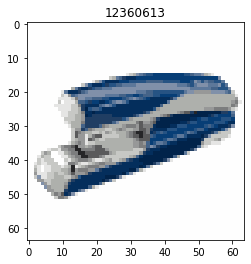

In [23]:
# MAIN
def main(container_path):
    image_dir = Path(container_path)
    count = 0
    img_hash = {}
    
    # first of all - correct answers
    correct_answers_DF = getCorrectAnswersDF();
    
    for file in image_dir.iterdir():
        count+=1;
        if count > 10: break;
        pic_id = file.stem
        
        img = plt.imread(file)
        
        img_normalized = normalize_image(img)
        
        img_pixels_colors = getScaledImageDataSorted(img_normalized)

        right_answerDF = correct_answers_DF[correct_answers_DF['pic_id'] == int(pic_id)]
        
        PopulateData(pic_id, img_pixels_colors, right_answerDF)
        
        plt.title(file.stem)
        plt.imshow(img_normalized)
        
        
    display(inputDataMock)
    inputData = pd.DataFrame(data=inputDataMock)
    display(inputData)
    
    #
main("datasets/1/images");

In [ ]:
print(inputDataMock)

## 2. Flights Departing from NYC

__You should be able to do this exercise after Lecture 4.__

For this exercise we will be using the famous nycflights13 data which contains the `airlines`, `airports`, `flights`, `planes`, and `weather` datasets. Please see the documentation (`nycflights13.pdf`) for further information.

**(a)** Load all files as pandas dataframes and display the first 5 rows of each dataset.

**(b)** Convert all temperature attributes to degree Celsius. We will be using this in what follows.

**(c)** Using OLS, investigate if flight distance is associated with arrival delay. You should be cautious regarding negative delays.

**(d)** Using OLS, investigate if departure delay is associated with arrival delay. Again,
   consider what to do with negative delays.

**(e)** Investigate whether departure delay is associated with weather conditions
   at the origin airport. This includes descriptives, plotting, regression modelling,
   considering missing values etc. For regression, do OLS, Ridge, Lasso, and Elastic Net.
   The analysis should also include seasonality trends as a "weather condition". You could,
   for instance, plot the daily departure delay with the date (or monthly). What are the
   three most important weather conditions when trying to predict departure delays?

**(f)** Is the age of the plane associated with delay? Do OLS, Ridge, Lasso, and Elastic Net.

**(g)** Do a principal component analysis of the weather at JFK using the following columns:
   temp, dewp, humid, wind_dir, wind_speed, precip, visib.
   How many principal components should be used to capture the variability in the weather data?

**(h)** Build regression models (OLS, Ridge, Lasso, and Elastic Net) that associates
   an airports lattitude with weather conditions (temp, dewp, humid, wind_dir, wind_speed,
   precip, visib). Remove all but the three most significant whether conditions and redo
   the analysis.

**(i)** On a map, plot the airports that have flights to them where the points that represent
   airports are relative in size to the average departure delay. You can see an example in "airports.png".

 **(j)** These questions require no code.
 - Suppose you are using Ridge Regression and you notice that the training error and the validation error are almost equal and fairly high. Would you say that the model suffers from high bias or high variance? Should you increase the regularization hyperparameter or reduce it?

- Why would you want to use:
        > Ridge Regression instead of plain Linear Regression (i.e. without any regularization)?
        > Lasso instead of Ridge Regression?
        > Elastic Net instead of Lasso?

## 3. Clustering of Handwritten Digits

__You should be able to do this exercise after Lecture 5.__

This exercise will depart from the famous MNIST dataset, and we are exploring several clustering techniques with it.. This is a ".mat" file, in order to load this file in an ipynb you have to use loadmat() function from scipy.io. (replace my path).

In [ ]:
from scipy.io import loadmat
mnist = loadmat('mnist-original')
mnist_data = mnist["data"].T
mnist_label = mnist["label"][0]
import numpy as np
print("Number of datapoints: {}\n".format(mnist_data.shape[0]))
print("Number of features: {}\n".format(mnist_data.shape[1]))
print("List of labels: {}\n".format(np.unique(mnist_label)))

There are 70,000 images, and each image has 784 features. This is because each image is 28×28 pixels,
and each feature simply represents one pixel’s intensity, from 0 (white) to 255 (black). Let’s take a peek at one digit from the dataset. All you need to do is grab an instance’s feature vector, reshape it to a 28×28 array, and display it using Matplotlib’s `imshow()` function:

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
index = 4
print("Value of datapoint no. {}:\n{}\n".format(index,mnist_data[index]))
print("As image:\n")
plt.imshow(mnist_data[index].reshape(28,28),cmap=plt.cm.gray_r)
plt.show()

**(a)** Perform k-means clustering with k=10 on this dataset.

**(b)** Using visualization techniques analogous to what we have done in the Clustering notebook
   for the faces data, can you determine the 'nature' of the 10 constructed clusters?
   Do the clusters (roughly) coincide with the 10 different actual digits?

**(c)** Perform a supervised clustering evaluation using adjusted rand index.
   Are the results stable, when you perform several random restarts of k-means?

**(d)** Now perform hierarchical clustering on the data.
   (in order to improve visibility in the constructed dendrograms, you can also use a
   much reduced dataset as constructed using sklearn.utils.resample shown below).
   Does the visual analysis of the dendrogram indicate a natural number of clusters?

**(e)** Using different cluster distance metrics (ward,single,average, etc.),
   what do the clusterings look like that are produced at the level of k=10 clusters?
   See the Clustering notebook for the needed Python code, including the fcluster
   method to retrieve 'plain' clusterings from the hierarchical clustering.

In [ ]:
small_mnist_data,small_mnist_label = skl.utils.resample(mnist.data,mnist.target,n_samples=200,replace='false')

**(f)** Do a DBSCAN clustering of the small dataset. Tweak the different parameters.

**(g)** Try to compare the different clustering methods on the MNIST dataset in the same way
   the book does on the faces dataset on pp. 195-206.

## 4. The Local Elections

__You should be able to do this exercise after Lecture 6.__

In the local elections of 2021, around 100 candidates stood for election for the city council of Horsens. 83 of them represented a national party, had more than one candidate and provided answers to the <a href="https://www.dr.dk/nyheder/politik/kandidattest">DR Candidate Test</a>, a test designed to help voters find out who they should vote for. In this test, the candidates answered 18 questions, which we will use as features in the following. The politicians belong to 9 parties, which will be our classes.

The numpy files `X_Horsens.npy` and `Y_Horsens.npy` contains the data. `Y_Horsens.npy` contains a letter representing the party to which each candidate belongs. The following parties are represented:

| Party letter | Party name | Party name (English) | Political position | Party color |
| :-: | :-: | :-: | :-: | :-: |
| A | Socialdemokratiet | Social Democrats | Centre-left | Red |
| B | Radikale Venstre | Social Liberal Party | Centre-left | Indigo |
| C | Det Konservative Folkeparti | Conservative People's Party | Right-wing | Green |
| D | Nye Borgerlige | New Right | Far-right | Black |
| F | Socialistisk Folkeparti | Socialist People's Party | Left-wing | Fuchsia |
| I | Liberal Alliance | Liberal Alliance | Right-wing | Cyan |
| O | Dansk Folkeparti | Danish People's Party | Far-right | Yellow |
| V | Venstre | Danish Liberal Party | Centre-right | Blue |
| Z* | Enhedslisten | Red-Green Alliance | Far-left | Dark red |

*_Note that, although the party letter of Enhedslisten is actually Ø, we will here use Z to avoid any complications with the wonderful Danish letters Æ, Ø and Å. Feel free to change the Z back to an Ø if you find that it does not cause any problems._

Meanwhile, `X_Horsens.npy` contains the answers to the test as numbers between -1.5 and 1.5, such that -1.5 is "Strongly disagree", -0.5 is "Disagree", 0.5 is "Agree" and 1.5 is "Strongly agree". The 18 questions concern, in order, subdivision, schools, windmills, building permits, tall buildings, housing, child care, culture, nursing homes, taxes, sports, refugees, nursing homes (again), public transportation, meat-free days, welfare, privatization, and religious minorities.

Both files can be imported using `numpy.load`.

__(a)__ How well do you (intuitively) expect that we can predict the partisan affiliation of a candidate based on their answers to the test?

__(b)__ Based on the answers from all 83 candidates for the Horsens city council, perform a Principal Component Analysis with 2 principal components. Plot the results in a figure using these 2 components as the axes. Label the points with the party letter and the appropriate color.

__(c)__ Comment on the results. You may consider the following questions for inspiration: Can the political parties be separated? Can the typical distinction of "left-wing" and "right-wing" be discerned? Which of the 18 questions (features) are most important?

The number of candidates (83) is on the (very) low side when we want to do machine learning. Luckily, the neighbouring city of Databorg had no less than 8,300 candidates standing for election, with a political environment similar to that of Horsens. In the following, we will use the data from Databorg. These are stored in the numpy files `X_Databorg.npy` and `Y_Databorg.npy` in same format as the Horsens data.

__(d)__ Once again, perform a Principal Component Analysis and visualize the results. Compare the results to those of the Horsens data.

Confident that we can predict the partisan affiliation of a politician reasonably well based on their answers to the test, we want to build a model that will allow us to distinguish between the 9 political parties. For this purpose, we split the data into a training and a validation set.

__(e)__ Split the data into a training and a validation set, with appropriate fractions.

First, we assume that a Naive Bayes approach is sufficient for our purposes.

__(f)__ Comment on the basic assumption of the Naive Bayes approach. Is this a reasonable assumption for the problem at hand?

__(g)__ Classify the instances of the validation set using a Naive Bayes approach. Comment on the results.

Assume instead that a _k_-nearest neighbour approach is sufficient for our  needs.

__(h)__ Using default settings of the _k_-NN classifier, classify the instances of the validation set. Comment on the performance.

__(i)__ Play around with different values of _k_. Decide on a "good" value of _k_. Comment on the results.

We now try to use a decision tree instead.

__(j)__ What is the _minimum_ depth of an appropriate decision tree? Why?

__(k)__ Build a decision tree with at least the depth from above. Play around with the tree depth. Include a figure that shows some relevant measure of the performance as a function of the tree depth. Comment on any issues of over-fitting. Decide on a tree which you will keep for later use. Can you do better than the _k_-NN classifier?

__(l)__ What are the most important features? Visualize this in an appropriate way. Does it match what you would expect? Compare to the results of the PCA analysis. Do we expect them to be the same? Why/why not?

We know that decision trees suffer from certain problems that may be solved by using decision forests.

__(m)__ Build a decision forest. Play around with the number of trees in the forest. Decide on a forest.

__(n)__ Extract the most important features. Comment and compare with previously obtained results.

Finally, we want to compare the models we have worked with so far (i.e., Naive Bayes, _k_-NN, decision tree and decision forest).

__(o)__ Compare the results of the in terms of confusion matrices, accuracy, precision, recall, and f-score. How well can we predict the partisan affiliation of a candidate based on their answers to a test? How does this compare with your intuition? 

## 5. Sentiment Analysis

__You should be able to do this exercise after Lecture 8.__

In this exercise we use the IMDb-dataset, which we will use to perform a sentiment analysis. The code below assumes that the data is placed in the same folder as this notebook. We see that the reviews are loaded as a pandas dataframe, and print the beginning of the first few reviews.

In [ ]:
import pandas as pd

reviews = pd.read_csv('reviews.txt', header=None)
labels = pd.read_csv('labels.txt', header=None)
Y = (labels=='positive').astype(np.int_)

print(type(reviews))
print(reviews.head())

**(a)** Split the reviews and labels in test, train and validation sets. The train and validation sets will be used to train your model and tune hyperparameters, the test set will be saved for testing.

**(b)** Use the `CountVectorizer` from `sklearn.feature_extraction.text` to create a Bag-of-Words representation of the reviews. (See an example of how to do this in chapter 7 of "Muller and Guido"). Only use the 10,000 most frequent words (use the `max_features`-parameter of `CountVectorizer`).

**(c)** Explore the representation of the reviews. How is a single word represented? How about a whole review?

**(d)** Train a neural network with a single hidden layer on the dataset, tuning the relevant hyperparameters to optimize accuracy. 

**(e)** Test your sentiment-classifier on the test set.

**(h)** Use the classifier to classify a few sentences you write yourselves. 

## 6. Speech Recognition

__You should be able to do this exercise after Lecture 9.__

In this exercise, we will work with the <a href="https://arxiv.org/pdf/1804.03209.pdf">Google Speech Command Dataset</a>, which can be downloaded from <a href="http://download.tensorflow.org/data/speech_commands_v0.02.tar.gz">here</a> (note: you do not need to download the full dataset, but it will allow you to play around with the raw audiofiles). This dataset contains 105,829 one-second long audio files with utterances of 35 common words.

We will use a subset of this dataset as indicated in the table below.

| Word | How many? | Class # |
| :-: | :-: | :-: |
| Yes | 4,044 | 3 |
| No | 3,941 | 1 |
| Stop | 3,872 | 2 |
| Go | 3,880 | 0 |

The data is given in the files `XSound.npy` and `YSound.npy`, both of which can be imported using `numpy.load`. `XSound.npy` contains spectrograms (_e.g._, matrices with a time-axis and a frequency-axis of size 62 (time) x 65 (frequency)). `YSound.npy` contains the class number, as indicated in the table above.

__(a)__ Explore and prepare the data, including splitting the data in training, validation and testing data, handling outliers, perhaps taking logarithms, etc. Data preparation is - as always - quite important. Document what you do.

__(b)__ Visualize a few examples of yes's, no's, stop's and go's, so that you have a reasonable intuitive understanding of the difference between the words.

__(c)__ Train a neural network and at least one other algorithm on the data. Find a good set of hyperparameters for each model. Do you think a neural network is suitable for this kind of problem? Why/why not?

__(d)__ Classify instances of the validation set using your models. Comment on the results in terms of metrics you have learned in the course.

__(e)__ Identify (a few) misclassified words, including what they are misclassified as. Visualize them as before, and compare with your intuitive understanding of how the words look. Do you find the misclassified examples surprising?

## 7. Group Assignment & Presentation



__You should be able to start up on this exercise after Lecture 1.__

*This exercise must be a group effort. That means everyone must participate in the assignment.*

In this assignment you will solve a data science problem end-to-end, pretending to be recently hired data scientists in a company. To help you get started, we've prepared a checklist to guide you through the project. Here are the main steps that you will go through:

1. Frame the problem and look at the big picture
2. Get the data
3. Explore and visualise the data to gain insights
4. Prepare the data to better expose the underlying data patterns to machine learning algorithms
5. Explore many different models and short-list the best ones
6. Fine-tune your models
7. Present your solution 

In each step we list a set of questions that one should have in mind when undertaking a data science project. The list is not meant to be exhaustive, but does contain a selection of the most important questions to ask. We will be available to provide assistance with each of the steps, and will allocate some part of each lesson towards working on the projects.

Your group must submit a _**single**_ Jupyter notebook, structured in terms of the first 6 sections listed above (the seventh will be a video uploaded to some streaming platform, e.g. YouTube, Vimeo, etc.).

### 1. Analysis: Frame the problem and look at the big picture
1. Find a problem/task that everyone in the group finds interesting
2. Define the objective in business terms
3. How should you frame the problem (supervised/unsupervised etc.)?
4. How should performance be measured?

### 2. Get the data
1. Find and document where you can get the data from
2. Get the data
3. Check the size and type of data (time series, geographical etc)

### 3. Explore the data
1. Create a copy of the data for explorations (sampling it down to a manageable size if necessary)
2. Create a Jupyter notebook to keep a record of your data exploration
3. Study each feature and its characteristics:
    * Name
    * Type (categorical, int/float, bounded/unbounded, text, structured, etc)
    * Percentage of missing values
    * Check for outliers, rounding errors etc
4. For supervised learning tasks, identify the target(s)
5. Visualise the data
6. Study the correlations between features
7. Identify the promising transformations you may want to apply (e.g. convert skewed targets to normal via a log transformation)
8. Document what you have learned

### 4. Prepare the data
Notes:
* Work on copies of the data (keep the original dataset intact).
* Write functions for all data transformations you apply, for three reasons:
    * So you can easily prepare the data the next time you run your code
    * So you can apply these transformations in future projects
    * To clean and prepare the test set
    
    
1. Data cleaning:
    * Fix or remove outliers (or keep them)
    * Fill in missing values (e.g. with zero, mean, median, regression ...) or drop their rows (or columns)
2. Feature selection (optional):
    * Drop the features that provide no useful information for the task (e.g. a customer ID is usually useless for modelling).
3. Feature engineering, where appropriate:
    * Discretize continuous features
    * Use one-hot encoding if/when relevant
    * Add promising transformations of features (e.g. $\log(x)$, $\sqrt{x}$, $x^2$, etc)
    * Aggregate features into promising new features
4. Feature scaling: standardise or normalise features

### 5. Short-list promising models
We expect you to do some additional research and train at **least one model per team member**.

1. Train mainly quick and dirty models from different categories (e.g. linear, SVM, Random Forests etc) using default parameters
2. Measure and compare their performance
3. Analyse the most significant variables for each algorithm
4. Analyse the types of errors the models make
5. Have a quick round of feature selection and engineering if necessary
6. Have one or two more quick iterations of the five previous steps
7. Short-list the top three to five most promising models, preferring models that make different types of errors

### 6. Fine-tune the system
1. Fine-tune the hyperparameters
2. Once you are confident about your final model, measure its performance on the test set to estimate the generalisation error

### 7. Present your solution
1. Document what you have done
2. Create a nice 15 minute video presentation with slides
    * Make sure you highlight the big picture first
3. Explain why your solution achieves the business objective
4. Don't forget to present interesting points you noticed along the way:
    * Describe what worked and what did not
    * List your assumptions and you model's limitations
5. Ensure your key findings are communicated through nice visualisations or easy-to-remember statements (e.g. "the median income is the number-one predictor of housing prices")
6. Upload the presentation to some online platform, e.g. YouTube or Vimeo, and supply a link to the video in the notebook.

## References

Géron, A. 2017, *Hands-On Machine Learning with Scikit-Learn and Tensorflow*, Appendix B, O'Reilly Media, Inc., Sebastopol.